In [1]:
import os

import numpy as np
import pysindy as ps

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import utils

In [2]:
dataset_folder = "D:/Robotics/neural-fly-main/neural-fly-main/data/experiment"

features1 = ['v']
RawData1 = utils.load_data(dataset_folder)
Data1 = utils.format_data(RawData1, features=features1)

In [114]:
v = torch.zeros((2511,3)) #first input feature
for row in range(len(v)):
    for column in range(3):
        v[row][column] = Data1[21][0][row][column]
        
v.requires_grad = True

In [115]:
features2 = ['T_sp']

Data2 = utils.format_data(RawData1, features=features2)

fu = torch.zeros((2511,3))
for row in range(len(fu)):
    fu[row][2] = Data2[21][0][row][0]
    
R = torch.zeros((2511,3,3))
features3 = ['R']

Data3 = utils.format_data(RawData1, features=features3)

for matrix in range(len(R)):
    for row in range(3):
        for column in range(3):
            R[matrix][row][column] = Data3[21][0][matrix][row][column]
            
Rfu = torch.zeros((2511,3)) #second input feature
for row in range(len(Rfu)):
    Rfu[row] = np.matmul(R[row],fu[row])
Rfu.shape
Rfu.requires_grad = True

In [116]:
acc = torch.zeros((2511,3)) # actual acceleration
for ele in range(2510):
    acc[ele] = (v[ele+1]-v[ele])/0.02
acc[2510] = acc[2509]

In [117]:
class Regression(nn.Module):
    def __init__(self, input_size, output_size):
        super(Regression, self).__init__()
        self.linear1 = nn.Linear(input_size, 8)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(8, 16)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(16, 24)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(24, 8)
        self.relu4 = nn.ReLU()
        self.linear5 = nn.Linear(8, output_size)
    
    def forward(self, x):
        out = x
        out = out.unsqueeze(1)
        out = self.linear1(out)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.relu2(out)
        out = self.linear3(out)
        out = self.relu3(out)
        out = self.linear4(out)
        out = self.relu4(out)
        out = self.linear5(out)
        return out
    
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.zeros_(m.bias.data)
    
model = Regression(1,2)

model.apply(init_weights)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [96]:
f1 = model(v[:,0])[:,0]
f2 = model(v[:,1])[:,0]
f3 = model(v[:,2])[:,0]
f4 = model(v[:,0])[:,1]
f5 = model(v[:,1])[:,1]
f6 = model(v[:,2])[:,1]
f7 = model(Rfu[:,0])[:,0]
f8 = model(Rfu[:,1])[:,0]
f9 = model(Rfu[:,2])[:,0]
f10 = model(Rfu[:,0])[:,1]
f11 = model(Rfu[:,1])[:,1]
f12 = model(Rfu[:,2])[:,1]
feature = torch.cat((f1.unsqueeze(1), f2.unsqueeze(1), f3.unsqueeze(1), f4.unsqueeze(1), f5.unsqueeze(1), f6.unsqueeze(1), f7.unsqueeze(1), f8.unsqueeze(1), f9.unsqueeze(1), f10.unsqueeze(1), f11.unsqueeze(1), f12.unsqueeze(1)), dim=1)
feature.shape

torch.Size([2511, 12])

In [97]:
E = torch.randn(12, 3)
E.requires_grad = True
E.shape

torch.Size([12, 3])

In [98]:
y = torch.matmul(feature, E)
y.requires_grad

True

In [99]:
loss = criterion(acc,y) + torch.sum(torch.abs(E))
loss

tensor(22.1757, grad_fn=<AddBackward0>)

In [100]:
torch.sum(torch.abs(E))

tensor(20.6393, grad_fn=<SumBackward0>)

In [29]:
loss.backward()

In [30]:
E.grad

tensor([[ 1.0279, -1.0300, -1.0067],
        [ 1.0006, -1.0004,  0.9998],
        [-0.9743, -1.0542,  0.9828],
        [-1.1015,  1.1133,  1.0537],
        [ 0.9987, -0.9986, -0.9979],
        [-1.1888,  1.1184,  1.1395],
        [-0.9987, -1.0040, -1.0064],
        [-0.9993, -1.0006,  0.9991],
        [-0.9567,  0.9653,  0.9431],
        [ 0.9979, -0.9937,  1.0100],
        [-1.0011, -0.9990,  1.0015],
        [-1.0685,  1.0549, -0.9100]])

In [31]:
optimizer2 = torch.optim.SGD([E], lr=0.1)
optimizer2.step()
optimizer2.zero_grad()

In [32]:
print(E.grad)

None


In [33]:
optimizer.step()

In [34]:
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.grad)


In [118]:
loss_history = []
num_epochs = 150

E = torch.randn(12, 3)
E.requires_grad = True
optimizer2 = torch.optim.Adam([E], lr=0.01)

for epoch in range(num_epochs):
    loss = 0
    optimizer.zero_grad()  # move optimizer zero_grad() outside the inner loop
    optimizer2.zero_grad()
    
    f1 = model(v[:,0])[:,0]
    f2 = model(v[:,1])[:,0]
    f3 = model(v[:,2])[:,0]
    f4 = model(v[:,0])[:,1]
    f5 = model(v[:,1])[:,1]
    f6 = model(v[:,2])[:,1]
    f7 = model(Rfu[:,0])[:,0]
    f8 = model(Rfu[:,1])[:,0]
    f9 = model(Rfu[:,2])[:,0]
    f10 = model(Rfu[:,0])[:,1]
    f11 = model(Rfu[:,1])[:,1]
    f12 = model(Rfu[:,2])[:,1]
    feature = torch.cat((f1.unsqueeze(1), f2.unsqueeze(1), f3.unsqueeze(1), f4.unsqueeze(1), f5.unsqueeze(1), f6.unsqueeze(1), f7.unsqueeze(1), f8.unsqueeze(1), f9.unsqueeze(1), f10.unsqueeze(1), f11.unsqueeze(1), f12.unsqueeze(1)), dim=1)

    #lasso_term = sum([torch.sum(torch.abs(param)) for param in model.parameters()])
    
    y = torch.matmul(feature, E)
    loss = criterion(acc,y)
     
    loss.backward(retain_graph = True)
    
    optimizer.step()  # move optimizer step() outside the inner loop
    optimizer2.step()
    loss /= len(v)
    loss_history.append(loss)
    #scheduler.step(loss)
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}")


Epoch [10/150], Loss: 0.0006
Epoch [20/150], Loss: 0.0006
Epoch [30/150], Loss: 0.0006
Epoch [40/150], Loss: 0.0005
Epoch [50/150], Loss: 0.0003
Epoch [60/150], Loss: 0.0002
Epoch [70/150], Loss: 0.0001
Epoch [80/150], Loss: 0.0001
Epoch [90/150], Loss: 0.0001
Epoch [100/150], Loss: 0.0001
Epoch [110/150], Loss: 0.0001
Epoch [120/150], Loss: 0.0001
Epoch [130/150], Loss: 0.0001
Epoch [140/150], Loss: 0.0001
Epoch [150/150], Loss: 0.0001


In [119]:
E

tensor([[-1.4976e-01, -1.7963e-03,  2.3738e-02],
        [-3.2129e-01, -4.9150e-01, -9.3227e-03],
        [-1.7382e-02,  1.2501e-02, -4.3612e-02],
        [ 4.8687e-01,  9.9511e-03, -1.1475e+00],
        [-4.6508e-01,  1.1256e+00, -6.6169e-01],
        [-2.2447e-01, -7.0069e-03, -1.5939e-01],
        [ 1.8956e+00,  2.3796e-02,  1.5251e-02],
        [-1.2857e+00,  1.1332e+00,  2.2844e-02],
        [-3.8741e-02,  1.9714e-02, -1.7747e+00],
        [ 8.5172e-01, -6.2340e-01, -9.7513e-01],
        [ 2.7806e-01, -5.7318e-01, -7.9620e-01],
        [ 3.0454e-01, -4.7603e-01,  2.3996e-01]], requires_grad=True)

In [120]:
threshold = 1e-4
E = E.detach()
E[E<threshold] = 0
E

tensor([[0.0000, 0.0000, 0.0237],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0125, 0.0000],
        [0.4869, 0.0100, 0.0000],
        [0.0000, 1.1256, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [1.8956, 0.0238, 0.0153],
        [0.0000, 1.1332, 0.0228],
        [0.0000, 0.0197, 0.0000],
        [0.8517, 0.0000, 0.0000],
        [0.2781, 0.0000, 0.0000],
        [0.3045, 0.0000, 0.2400]])

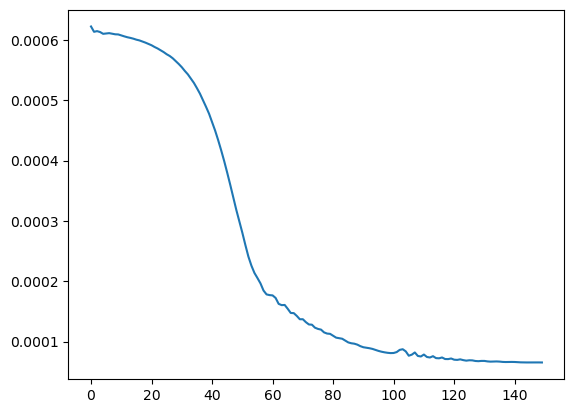

In [121]:
loss_history = np.array([tensor.item() for tensor in loss_history])
plt.plot(loss_history)

In [122]:
f1 = model(v[:,0])[:,0]
f2 = model(v[:,1])[:,0]
f3 = model(v[:,2])[:,0]
f4 = model(v[:,0])[:,1]
f5 = model(v[:,1])[:,1]
f6 = model(v[:,2])[:,1]
f7 = model(Rfu[:,0])[:,0]
f8 = model(Rfu[:,1])[:,0]
f9 = model(Rfu[:,2])[:,0]
f10 = model(Rfu[:,0])[:,1]
f11 = model(Rfu[:,1])[:,1]
f12 = model(Rfu[:,2])[:,1]
feature = torch.cat((f1.unsqueeze(1), f2.unsqueeze(1), f3.unsqueeze(1), f4.unsqueeze(1), f5.unsqueeze(1), f6.unsqueeze(1), f7.unsqueeze(1), f8.unsqueeze(1), f9.unsqueeze(1), f10.unsqueeze(1), f11.unsqueeze(1), f12.unsqueeze(1)), dim=1)

y = torch.matmul(feature, E)

In [123]:
y = y.detach().numpy()


In [124]:
acc = acc.detach().numpy()

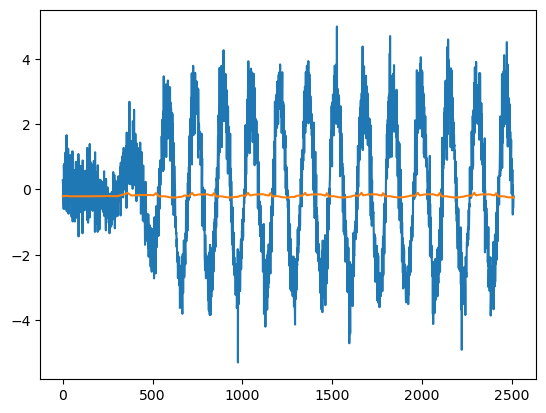

In [130]:
plt.plot(acc[:,2])
plt.plot(y[:,2])

In [68]:
y

array([[-0.001591  , -0.00020916, -0.00043068],
       [-0.0015486 , -0.00027268, -0.00033662],
       [-0.00156784, -0.00014729, -0.00040521],
       ...,
       [-0.0019428 ,  0.00028066,  0.00033704],
       [-0.00201681,  0.00033237,  0.00038207],
       [-0.00212075,  0.00041848,  0.000434  ]], dtype=float32)